<a href="https://colab.research.google.com/github/Edu-Brasil/projetoUnivesp/blob/master/PI4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from google.colab import files

# 1. Fazer a requisição à API do TJSP
url = "https://api-publica.datajud.cnj.jus.br/api_publica_tjsp/_search"
api_key = "APIKey cDZHYzlZa0JadVREZDJCendQbXY6SkJlTzNjLV9TRENyQk1RdnFKZGRQdw=="

payload = json.dumps({
  "size": 10000,
  "query": {
    "match": {"classe.codigo": 12729}  # 12729 (Exec. de Med. Alternativas)
  },
  "sort": [{"dataAjuizamento": {"order": "desc"}}]
})

headers = {
  'Authorization': api_key,
  'Content-Type': 'application/json'
}

response = requests.request("POST", url, headers=headers, data=payload)
dados_dict = response.json()

# 2. Processar os dados em um DataFrame
processos = []

for processo in dados_dict['hits']['hits']:
    numero_processo = processo['_source']['numeroProcesso']
    grau = processo['_source']['grau']
    classe = processo['_source']['classe']['nome']
    assuntos = processo['_source']['assuntos']
    data_ajuizamento = processo['_source']['dataAjuizamento']
    ultima_atualizacao = processo['_source']['dataHoraUltimaAtualizacao']
    formato = processo['_source']['formato']['nome']
    codigo = processo['_source']['orgaoJulgador']['codigo']
    orgao_julgador = processo['_source']['orgaoJulgador']['nome']
    municipio = processo['_source']['orgaoJulgador'].get('codigoMunicipioIBGE', 'Não informado')  # Tratamento de erro
    sort = processo['sort'][0]

    try:
        movimentos = processo['_source']['movimentos']
    except:
        movimentos = []

    processos.append([numero_processo, classe, data_ajuizamento, ultima_atualizacao, formato, \
                      codigo, orgao_julgador, municipio, grau, assuntos, movimentos, sort])

df = pd.DataFrame(processos, columns=['numero_processo', 'classe', 'data_ajuizamento', 'ultima_atualizacao', \
                                      'formato', 'codigo', 'orgao_julgador', 'municipio', 'grau', 'assuntos', 'movimentos', 'sort'])

# Funções auxiliares para transformar os dados
def converte_data(data_str):
    return pd.to_datetime(data_str).tz_convert('America/Sao_Paulo')

def gera_lista_assuntos(assuntos_do_df):
    lst_assuntos = []
    for assunto in assuntos_do_df:
        try:
            lst_assuntos.append(assunto.get('nome'))
        except:
            lst_assuntos.append('')
    return lst_assuntos

def gera_lista_movimentos(movimentos):
    lst_movimentos_final = []
    for movimento in movimentos:
        codigo = movimento.get('codigo')
        nome = movimento.get('nome')
        data_hora = movimento.get('dataHora')
        if data_hora:
            data_hora = converte_data(data_hora)
        lst_movimentos_final.append([codigo, nome, data_hora])
    return lst_movimentos_final

df['assuntos'] = df['assuntos'].apply(gera_lista_assuntos)
df['movimentos'] = df['movimentos'].apply(gera_lista_movimentos)
df['data_ajuizamento'] = df['data_ajuizamento'].apply(converte_data)
df['ultima_atualizacao'] = df['ultima_atualizacao'].apply(converte_data)
df['movimentos'] = df['movimentos'].apply(lambda x: sorted(x, key=lambda tup: tup[2], reverse=False))

# 3. Gravação dos arquivos

# Grava o DataFrame como arquivo CSV
df.to_csv('anpp.csv', sep=',', header=True, index=False)

# Grava o arquivo de texto com os movimentos
with open('movimentos_anpp.txt', 'w') as file:
    for index, row in df.iterrows():
        file.write(f"Autos n. {row['numero_processo']}, Classe: {row['classe']}\n")
        file.write(f"Ajuizamento: {row['data_ajuizamento']}\n")
        file.write(f"Assuntos: {row['assuntos']}\n\n")
        for movimento in row['movimentos']:
            file.write(f"{str(movimento[2])} | Cód: {str(movimento[0])} | Mov.: {movimento[1]} \n")
        file.write('\n-----------------------------------------------------------------------------\n\n')

# Download dos arquivos gerados
files.download('anpp.csv')
files.download('movimentos_anpp.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype                            
---  ------              --------------  -----                            
 0   numero_processo     10000 non-null  object                           
 1   classe              10000 non-null  object                           
 2   data_ajuizamento    10000 non-null  datetime64[ns, America/Sao_Paulo]
 3   ultima_atualizacao  10000 non-null  datetime64[ns, America/Sao_Paulo]
 4   formato             10000 non-null  object                           
 5   codigo              10000 non-null  int64                            
 6   orgao_julgador      10000 non-null  object                           
 7   municipio           10000 non-null  object                           
 8   grau                10000 non-null  object                           
 9   assuntos            10000 non-null  object                    

In [ ]:
df["assuntos"].value_counts()

,count
assuntos,
[Acordo de Não Persecução Penal],9951
[Pena de Multa],14
[Falsificação de documento público],9
[Falsificação de papéis públicos ],8
[Execução Penal e de Medidas Alternativas],3
[Crimes de Trânsito],2
[Pena Restritiva de Direitos],2
[Atos Processuais],2
"[Prestação Pecuniária, Prestação de Serviços à Comunidade, Acordo de Não Persecução Penal]",2


In [ ]:
mask = df["assuntos"].apply(lambda x: "Acordo de Não Persecução Penal" in x)
df_anpp = df[mask]

# Usar aspas simples dentro da string
print(f'Total de Registros: {len(df_anpp)}')
print(f"Data final: {df_anpp['data_ajuizamento'].max()}")
print(f"Data inicial: {df_anpp['data_ajuizamento'].min()}")


Total de Registros: 9957
Data final: 2024-07-31 17:50:38-03:00
Data inicial: 2023-08-14 11:23:58-03:00


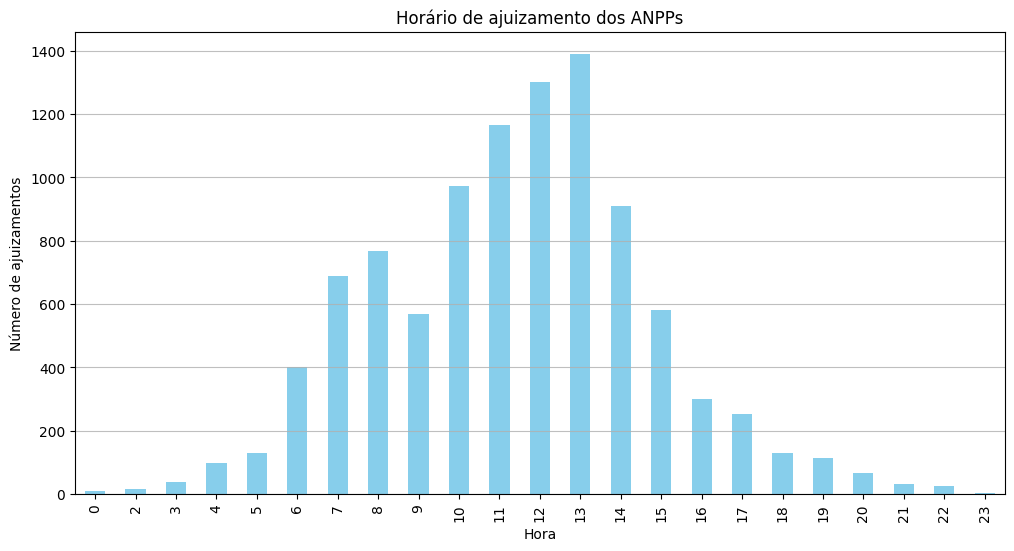

In [ ]:
# Horário em que os ANPPs foram ajuizados

contagem = df_anpp['data_ajuizamento'].dt.hour.value_counts().sort_index()
plt.figure(figsize=(12, 6))
contagem.plot(kind='bar', color='skyblue')
plt.title('Horário de ajuizamento dos ANPPs')
plt.xlabel('Hora')
plt.ylabel('Número de ajuizamentos')
plt.grid(axis='y', alpha=0.8)
plt.savefig('horario_anpp.jpg')
plt.show()

In [ ]:
display(contagem[8:19])
ajuizamentos_expediente = contagem[8:19].sum()
ajuizamentos_expediente

,count
data_ajuizamento,
9,568
10,973
11,1166
12,1300
13,1390
14,909
15,581
16,300
17,254


7685

In [ ]:
display(contagem[0:8])
display(contagem[19:])
ajuizamentos_fora = contagem[0:8].sum() + contagem[19:].sum()
ajuizamentos_fora

,count
data_ajuizamento,
0,8
2,15
3,38
4,98
5,130
6,401
7,689
8,766


,count
data_ajuizamento,
20,67
21,32
22,25
23,3


2272

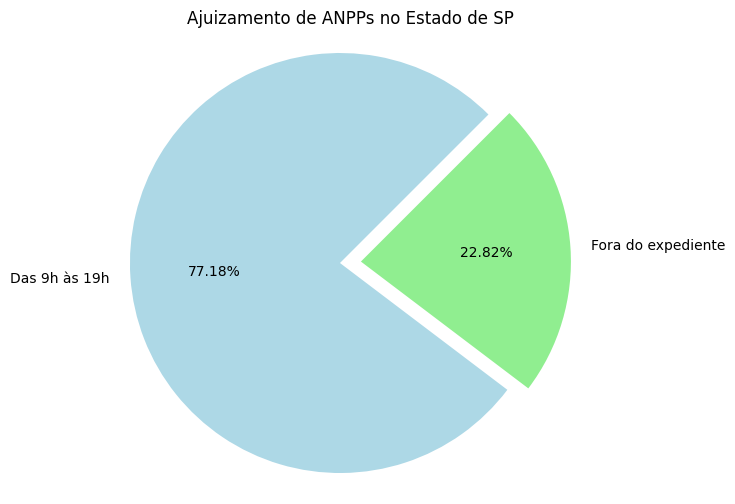

In [ ]:
labels = ['Das 9h às 19h', 'Fora do expediente']

sizes = [ajuizamentos_expediente, ajuizamentos_fora]

colors = ['lightblue', 'lightgreen']

# Explosão da fatia
explode = (0.1, 0)

# Gerando o gráfico
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.2f%%', startangle=45)

plt.title('Ajuizamento de ANPPs no Estado de SP')

plt.axis('equal')
plt.savefig('pizza_anpp.jpg')
plt.show()

In [ ]:
df_anpp.set_index('data_ajuizamento', inplace=True)

In [ ]:
df_resampled = df_anpp.resample('M').size()
df_resampled = df_resampled[1:] # Excluímos a primeira série de dados, que pode não estar completa (em razão do limite da resposta)
x = []
y = []
for index, value in df_resampled.items():
    x.append(f'Mês de {str(index)[:7]}')
    y.append(value)

In [ ]:
# Ajuizamentos mensais
df_resampled

,0
data_ajuizamento,
2023-09-30 00:00:00-03:00,997
2023-10-31 00:00:00-03:00,1135
2023-11-30 00:00:00-03:00,833
2023-12-31 00:00:00-03:00,653
2024-01-31 00:00:00-03:00,589
2024-02-29 00:00:00-03:00,705
2024-03-31 00:00:00-03:00,858
2024-04-30 00:00:00-03:00,926
2024-05-31 00:00:00-03:00,834


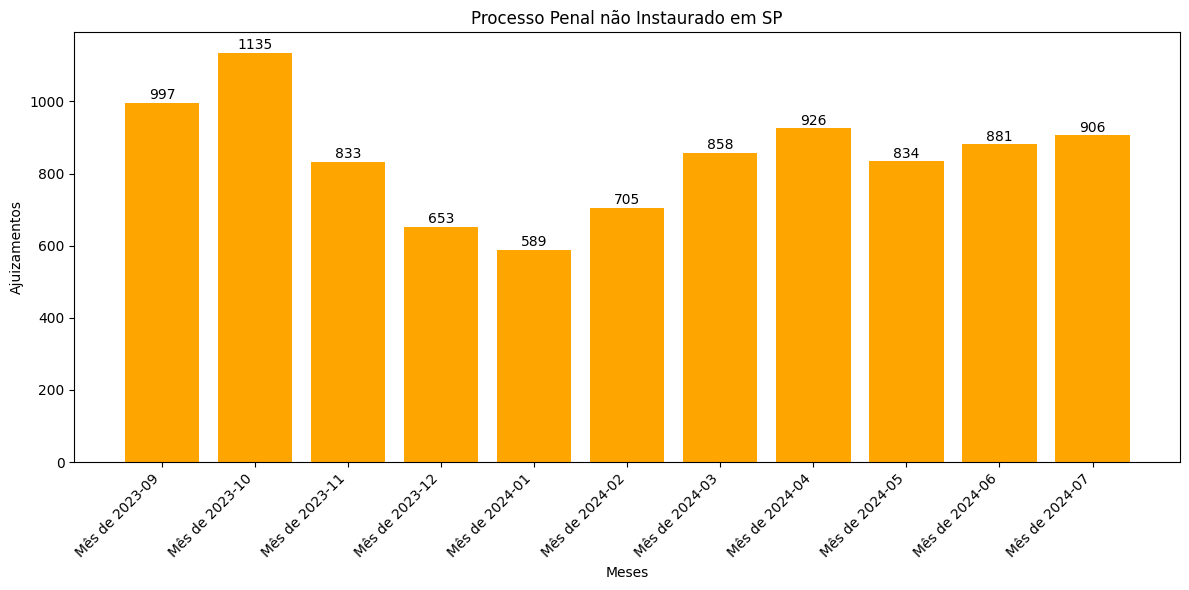

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(x, y, color='orange')

plt.xlabel('Meses')
plt.ylabel('Ajuizamentos')
plt.title('Processo Penal não Instaurado em SP')
plt.xticks(rotation=45,ha='right')

for i in range(len(x)):
    plt.text(x=x[i], y=y[i]+10, s=str(y[i]), ha='center')

plt.tight_layout()
plt.savefig('n_ajuizamentos_anpp.jpg')
plt.show()

In [ ]:
top_100 = df_anpp.groupby(['municipio', 'orgao_julgador'])['codigo'].count().sort_values(ascending=False).head(100)
with open('top_100_ajuizamentos_anpp.txt', 'w') as file:
    for index, value in top_100.items():
        texto = f"{index[0]} | {index[1]} |{value}"
        file.write(texto + '\n')
        print(texto)

Não informado | 05 EXECUCOES CRIMINAIS DE CENTRAL |1059
Não informado | 02 EXECUCOES CRIMINAIS DE CENTRAL |232
Não informado | EXECUCOES CRIMINAIS DE GUARULHOS |217
Não informado | EXECUCOES CRIMINAIS DE SAO JOSE DO RIO PRETO |215
Não informado | 02 CRIMINAL DE BOTUCATU |172
Não informado | JURI/EXECUCOES DE PIRACICABA |158
Não informado | JURI/EXECUCOES DE SOROCABA |149
Não informado | JURI/EXECUCOES DE SAO JOSE DOS CAMPOS |146
Não informado | JURI/EXECUCOES DE OSASCO |140
Não informado | JURI/EXECUCOES/INFANCIA E JUVENTUDE DE PRAIA GRANDE |138
Não informado | 02 EXECUCOES CRIMINAIS DE BAURU |138
Não informado | EXECUCOES CRIMINAIS DE MARILIA |137
Não informado | JURI/EXEC./INF.JUV. DE RIO CLARO |135
Não informado | JURI/EXEC./INF.JUV. DE FRANCO DA ROCHA |128
Não informado | JURI/EXEC./INF.JUV. DE MAUA |115
Não informado | 01 CRIMINAL DE ITAQUAQUECETUBA |111
3549904 | JURI/EXECUCOES DE SAO JOSE DOS CAMPOS |111
Não informado | 01 EXECUCOES CRIMINAIS DE TAUBATE |110
Não informado | 01 C